In [1]:
import backtrader as bt
import pandas as pd


In [11]:
EURUSD_2016 = pd.read_csv("data/EURUSD_2016.csv")
EURUSD_2016.head()

,Gmt time,Open,High,Low,Close,Volume
0,01.01.2015 00:00:00.000,1.20976,1.20976,1.20976,1.20976,0.0
1,01.01.2015 00:01:00.000,1.20976,1.20976,1.20976,1.20976,0.0
2,01.01.2015 00:02:00.000,1.20976,1.20976,1.20976,1.20976,0.0
3,01.01.2015 00:03:00.000,1.20976,1.20976,1.20976,1.20976,0.0
4,01.01.2015 00:04:00.000,1.20976,1.20976,1.20976,1.20976,0.0


In [13]:
EURUSD_2016.describe()

,Open,High,Low,Close,Volume
count,527040.000000,527040.000000,527040.000000,527040.000000,527040.000000
mean,1.110045,1.110128,1.109963,1.110045,92.499416
std,0.029199,0.029200,0.029198,0.029199,104.045782
min,1.046270,1.046560,1.046240,1.046280,0.000000
25%,1.089000,1.089140,1.088880,1.089000,0.000000
50%,1.110920,1.110920,1.110920,1.110920,63.820000
75%,1.129210,1.129340,1.129070,1.129200,145.830000
max,1.210500,1.210730,1.210430,1.210500,1624.280000


In [33]:
data = pd.read_csv("data/EURUSD_2016.csv", parse_dates=["Gmt time"], index_col="Gmt time", 
                   date_parser=lambda x: pd.to_datetime(x, format="%d.%m.%Y %H:%M:%S.%f"))

C:\Users\fpicaso\AppData\Local\Temp\ipykernel_28432\1149764442.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv("data/EURUSD_2016.csv", parse_dates=["Gmt time"], index_col="Gmt time",


C:\Users\fpicaso\AppData\Local\Temp\ipykernel_28916\2795304406.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv("data/EURUSD_2016.csv", parse_dates=["Gmt time"], index_col="Gmt time",


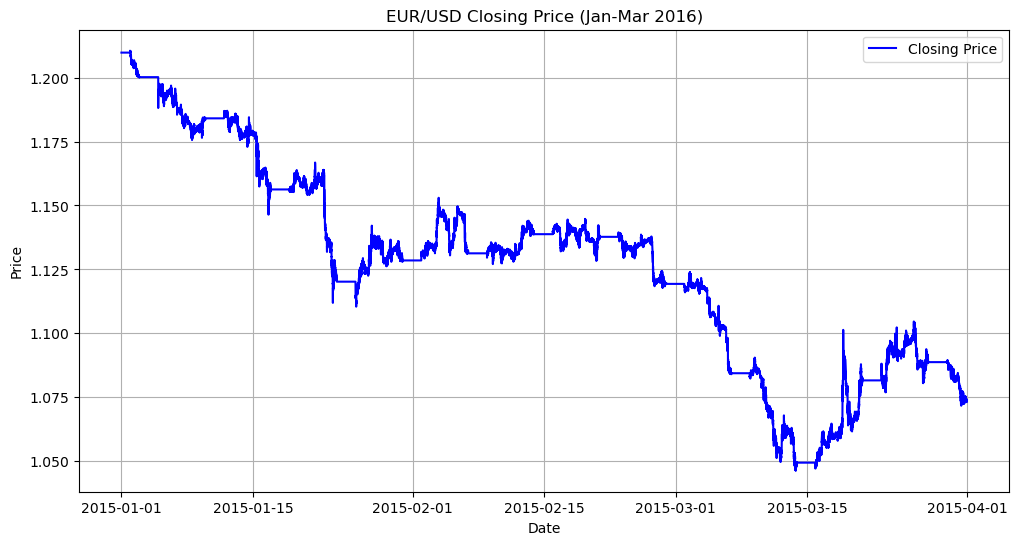

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("data/EURUSD_2016.csv", parse_dates=["Gmt time"], index_col="Gmt time",
                   date_parser=lambda x: pd.to_datetime(x, format="%d.%m.%Y %H:%M:%S.%f"))

# Filter for first 3 months (January - March)
data_q1 = data.loc["2015-01-01":"2015-03-31"]

# Plot closing price over time
plt.figure(figsize=(12, 6))
plt.plot(data_q1.index, data_q1["Close"], label="Closing Price", color="blue")

# Formatting
plt.title("EUR/USD Closing Price (Jan-Mar 2016)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [9]:
data_q1.describe()

,Open,High,Low,Close,Volume
count,1.440000e+03,1.440000e+03,1.440000e+03,1.440000e+03,1440.0
mean,1.085640e+00,1.085640e+00,1.085640e+00,1.085640e+00,0.0
std,1.110609e-14,1.110609e-14,1.110609e-14,1.110609e-14,0.0
min,1.085640e+00,1.085640e+00,1.085640e+00,1.085640e+00,0.0
25%,1.085640e+00,1.085640e+00,1.085640e+00,1.085640e+00,0.0
50%,1.085640e+00,1.085640e+00,1.085640e+00,1.085640e+00,0.0
75%,1.085640e+00,1.085640e+00,1.085640e+00,1.085640e+00,0.0
max,1.085640e+00,1.085640e+00,1.085640e+00,1.085640e+00,0.0


In [41]:

# Define Strategy
class MomentumStrategy(bt.Strategy):
    params = dict(stop_loss=0.005, take_profit=0.01)  # 50 pips SL, 100 pips TP

    def __init__(self):
        self.entry_price = None

    def next(self):
        if len(self.data) < 3:  # Need at least 3 candles to analyze trend
            return

        # Detect bullish momentum (higher closes, even if some candles are red)
        bullish_momentum = (self.data.close[-2] > self.data.close[-3] and
                            self.data.close[-1] > self.data.close[-2] and
                            self.data.close[0] > self.data.close[-1])

        # Detect bearish momentum (lower closes)
        bearish_momentum = (self.data.close[-2] < self.data.close[-3] and
                             self.data.close[-1] < self.data.close[-2] and
                             self.data.close[0] < self.data.close[-1])

        if not self.position:  # No active trade
            if bullish_momentum:  # Buy Signal
                self.buy()
                self.entry_price = self.data.close[0]
            elif bearish_momentum:  # Sell Signal
                self.sell()
                self.entry_price = self.data.close[0]
        else:  # Manage Open Trade
            if self.position.size > 0 and (self.data.close[0] >= self.entry_price * (1 + self.params.take_profit) or
                                           self.data.close[0] <= self.entry_price * (1 - self.params.stop_loss)):
                self.sell()  # Exit Long
            elif self.position.size < 0 and (self.data.close[0] <= self.entry_price * (1 - self.params.take_profit) or
                                             self.data.close[0] >= self.entry_price * (1 + self.params.stop_loss)):
                self.buy()  # Exit Short

# Load Forex Data (Modify for your source)
#data = pd.read_csv("data/EURUSD_2016.csv", parse_dates=["Gmt time"], index_col="Gmt time")
data_feed = bt.feeds.PandasData(dataname=data_jan)

# Backtesting Engine
cerebro = bt.Cerebro()
cerebro.addstrategy(MomentumStrategy, stop_loss=0.005, take_profit=0.01)
cerebro.adddata(data_feed)
cerebro.broker.set_cash(10000)
cerebro.broker.setcommission(commission=0.0002, leverage=30)

# Run Backtest
cerebro.run()
cerebro.plot()


<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 4 Axes>]]